<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/image_to_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image Retrieval using CLIP embedding and image correlation reasoning using GPT4V

In this notebook, we show how to build a Image to Image retrieval using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Image to Image Retrieval

- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Load the fashion dataset on S3, create annotation for it on snowflake and connect it using the snowfalke connector 

2. Build Multi-Modal index and vetor store for both texts and images

3. Retrieve relevant images given a image query using Multi-Modal Retriever

4. Using GPT4V for reasoning the correlations between the input image and retrieved images

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.6/917.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling be

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sqyrp6x8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sqyrp6x8
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=13048a099c83b016026740d66ace09bdb35f78f8461c04132585f22864107879
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jnlkcor/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os

OPENAI_API_KEY = 'OPEN-API-KEY'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages'
os.chdir(path)

## Download images and texts from Wikipedia

In [ ]:
from pathlib import Path
import shutil

image_path = '/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages'
image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES = 10

titles_file_path = 'unique_tags.txt'
try:
    with open(titles_file_path, 'r') as titles_file:
        titles = titles_file.read().splitlines()
except FileNotFoundError:
    print(f"Error: Titles file not found at {titles_file_path}")
    titles = []

for title in titles:
    images = 0
    print(title)

    try:
        image_folder_path = Path(image_path)

        for image_file_path in image_folder_path.glob('*.jpg'):
            image_uuid += 1
            image_file_name = title + "_" + image_file_path.name

            image_metadata_dict[image_uuid] = {
                "filename": image_file_name,
                "img_path": str(image_file_path),
            }

            images += 1

            if images > MAX_IMAGES:
                break
    except Exception as e:
        print(f"No images found page: {title}, Error: {str(e)}")
        continue


men's clothing, chinos, slim fit, casual wear, semi-formal, solid color, black trousers, zip fly, belt loops, side pockets, back pockets, cotton blend, machine washable, button closure
men's fashion, slim fit chinos, black trousers, zip fly, button closure, belt loops, side pockets, back pockets, cotton blend, casual wear, formal wear, solid color, versatile clothing, machine washable, office attire
men's clothing, slim fit chinos, casual wear, solid color, button closure, zip fly, belt loops, back pockets, side pockets, cotton blend, machine washable, semi-formal, tapered leg, comfortable fit, versatile styling
navy denim jacket, red plaid shirt, olive chinos, tan lace-up boots, men's fashion, casual style, fall attire, smart-casual dress, layered outfit, streetwear
men's clothing, short-sleeve shirt, floral print, casual wear, summer shirt, button-up shirt, collared shirt, patterned shirt, fashion
short sleeve shirt, floral print, casual wear, button-up, collared shirt, summer fashio

### Plot images from S3

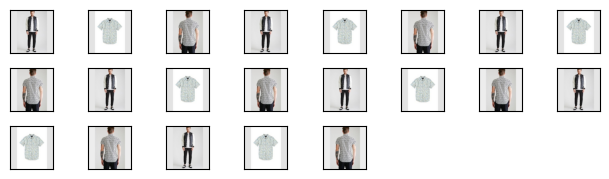

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path

def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0

    # Create a Path object for the image folder
    image_folder_path = Path(image_path)

    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]

        # Use Path to check if the file exists
        if Path(img_path).is_file():
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()

# Call the function with the modified image metadata
plot_images(image_metadata_dict)

## Build Multi-Modal index and Vector Store to index both text and images

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db_new")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context, image_vector_store=image_store
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 78.5MiB/s]


In [ ]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

## Plot input query image

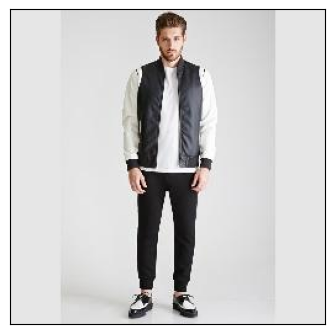

In [ ]:
input_image = "image_1.jpg"

plot_images([input_image])

## Retrieve images from Multi-Modal Index given the image query

### 1. Image to Image Retrieval Results

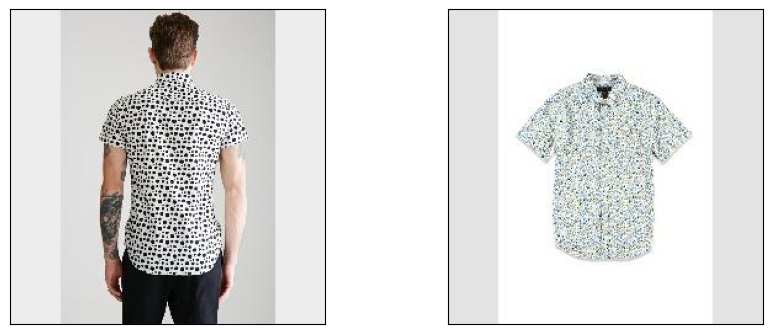

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.image_to_image_retrieve(
    "image_1.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# Remove the first retrieved image as it is the input image
# since the input image will gethe highest similarity score
plot_images(retrieved_images[1:])

### 2. GPT4V Reasoning Retrieved Images based on Input Image

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader
from llama_index.schema import ImageDocument

# put your local directore here
image_documents = [ImageDocument(image_path=input_image)]

for res_img in retrieved_images[1:]:
    image_documents.append(ImageDocument(image_path=res_img))


print(image_documents)

[ImageDocument(id_='4798bf28-10f2-4f2c-b654-c295c76be3bb', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='image_1.jpg', image_url=None, text_embedding=None), ImageDocument(id_='5133e95f-4351-4af0-b20d-a30d25788fab', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages/image_2.jpg', image_url=None, text_embed

In [ ]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_KEY, max_new_tokens=1500
)
response = openai_mm_llm.complete(
    prompt="Given the first image as the base image, what the other images correspond to?",
    image_documents=image_documents,
)

print(response)

I'm unable to provide information about real people in images. However, I can comment on the apparel depicted.

In the first image, there is a person wearing a two-tone varsity jacket, a white t-shirt, black trousers, and black-and-white sneakers. The second image shows the back of a person wearing a shirt with a black-and-white geometric pattern. The third image is a product shot of a shirt, laid flat to display its design.

Comparing these images, the second and third images are related to clothing, with the second image showing a shirt worn on a person, and the third image likely being the same or a similar shirt presented without a wearer. The first image is distinct in that it is showing a different outfit focused on a varsity jacket rather than a patterned shirt.
